### Anonymization of Mobile Location Data ###

This notebook provides a walkthrough of the anonymization methodology outlined in section 3 of McNicholas and Mass (2021a) using the publicly accessible T-Drive dataset from Microsoft Research, which contains GPS traces of taxicabs in Beijing. 

Below privacy models geo-indistinguishability and k-anonymity are combined in an effort to protect personally identifiable information (i.e. location data). In this framework, GPS location data is obfscated under the notion of geo-indistinguishability following the work of (Andres et al., 2013). Obfuscated locations are subsequently generalized through rounding (Krumm, 2007). This combinatorial approach is similar to that used by (Kraemer, et al. 2020) which combined k-anonymity with differential privacy to protect the privacy of mobility traces.

1. Import relevant python libraries and define bounding box for data and mapping

2. Retrieve and subset location data 

3. Plot distribution of location data

4. Anonymize location data by combining Geo-Indistinguishability (Andres et al., 2013) and K-Anonymity (Dwork, 2006)

5. Display location data at each stage of anonymization (similar to Fig. 3 in McNicholas and Mass, 2020a)

6. Show the distribution of pressure errors drawn from a sample of real IBM SPO errors 

7. Create synthetic pressure observations at social network check-in location to simulate a network of SPOs. Assign pressure errors to synthetic pressure observations using a random sample of real IBM SPO errors

8. Show data in table format to highlight how the location and pressure data would look before and after anonymization

9. Display synthetic pressure observations, at each stage of anonymization.

10. Show the distribution of pressure observations errors, at each stage of anonymization, and plot the results on a map.

In [1]:
### --- (1) - ###

#Import relevant python libraries
#Define bounding box for data and mapping

import xarray as xr
from matplotlib import pyplot as plt
from matplotlib import colors
import cmasher as cmr
import matplotlib
import numpy as np
import pandas as pd
from datetime import datetime

#Use cartopy for adding states, borders, lakes, etc. to maps
from cartopy.feature import NaturalEarthFeature,BORDERS,LAKES,COLORS
import cartopy.crs as crs
import colorcet as cc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

#Define perceptually uniform colormaps 
cmapp2 = cc.cm.rainbow_bgyrm_35_85_c71
cmapp = cmr.get_sub_cmap('cmr.heat', 0, 0.85) #Remove white part of colormap

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
#ax1.add_feature(states) #, linewidth=.5, edgecolor="black")
land_50m = NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor='none')

#Define bounding box for location data 
minLat = 39.375; maxLat = minLat+1
minLng = 115.875; maxLng = minLng+1

#Apply cartopy map features to plot
def add_map(ax,clr,lw):
    ax.add_feature(states,zorder=1)
    ax.add_feature(BORDERS,zorder=1,linewidth=0.5)
    ax.add_feature(land_50m,zorder=1)
    ax.add_feature(states,edgecolor=clr,zorder=1,lw=lw)
    ax.add_feature(LAKES, edgecolor=clr)

#Add grid lines and labels to cartopy map
def add_gridlines(ax,xl,yl,clr, fs):
    gl = ax.gridlines(crs=crs.PlateCarree(), draw_labels=True,
                      linewidth=0.25, color=clr, alpha=1, linestyle='--')

    gl.xlabels_bottom = xl
    gl.xlabels_top = False
    gl.ylabels_left = yl
    gl.ylabels_right = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(minLng-0.25,maxLng+0.25,0.25))
    gl.ylocator = mticker.FixedLocator(np.arange(minLat-0.25,maxLat+0.25,0.25))
    gl.xlabel_style = {'size': fs, 'color': clr}
    gl.ylabel_style = {'size': fs, 'color': clr}
    return gl

#Define functions to compute mean absolute error 
def mae(arr,axis):
        return np.nanmean(np.abs(arr),axis=axis)

#Define function to compute root mean squared error
def rmse(arr,axis):
        return np.sqrt(np.nanmean(arr**2.0,axis=axis))
    
#Compute error statistics for gridded SPOs
def calc_pres_err(dss1):
    pres_grid = pres_eq(dss1['lat_grid'].values,dss1['lng_grid'].values)         
    err_anon = dss1['pressure'].values-pres_grid
    return err_anon

#Define function to display pandas dataframes side by side
from IPython.core.display import display, HTML
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))     

#Increase width of notebook to fill screen
from IPython.display import display_html 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
### --- (2) --- ###
#Retrieve and subset location data 

#Retrieve T-drive location data over a period of 24-hr and 5-min (note data in these netcdf files has already been subset to the bounding box specified above)
#For access to the full T-drive dataset see the link in the README

#Retrieve mobile location data over 24-hr period
ds = xr.open_dataset("location_datasets/tdrive_data_24hr.nc")
llats_24hr = ds['latitude'].values
llngs_24hr = ds['longitude'].values
ds.close()

#Retrieve mobile location data over a 5-min period
ds = xr.open_dataset("location_datasets/tdrive_data_5min.nc")
llats_5min = ds['latitude'].values
llngs_5min = ds['longitude'].values
ds.close()

/home/disk/p/cmcnich/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1123: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = matplotlib.axes.Axes.imshow(self, img, *args, **kwargs)
/home/disk/p/cmcnich/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/home/disk/p/cmcnich/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


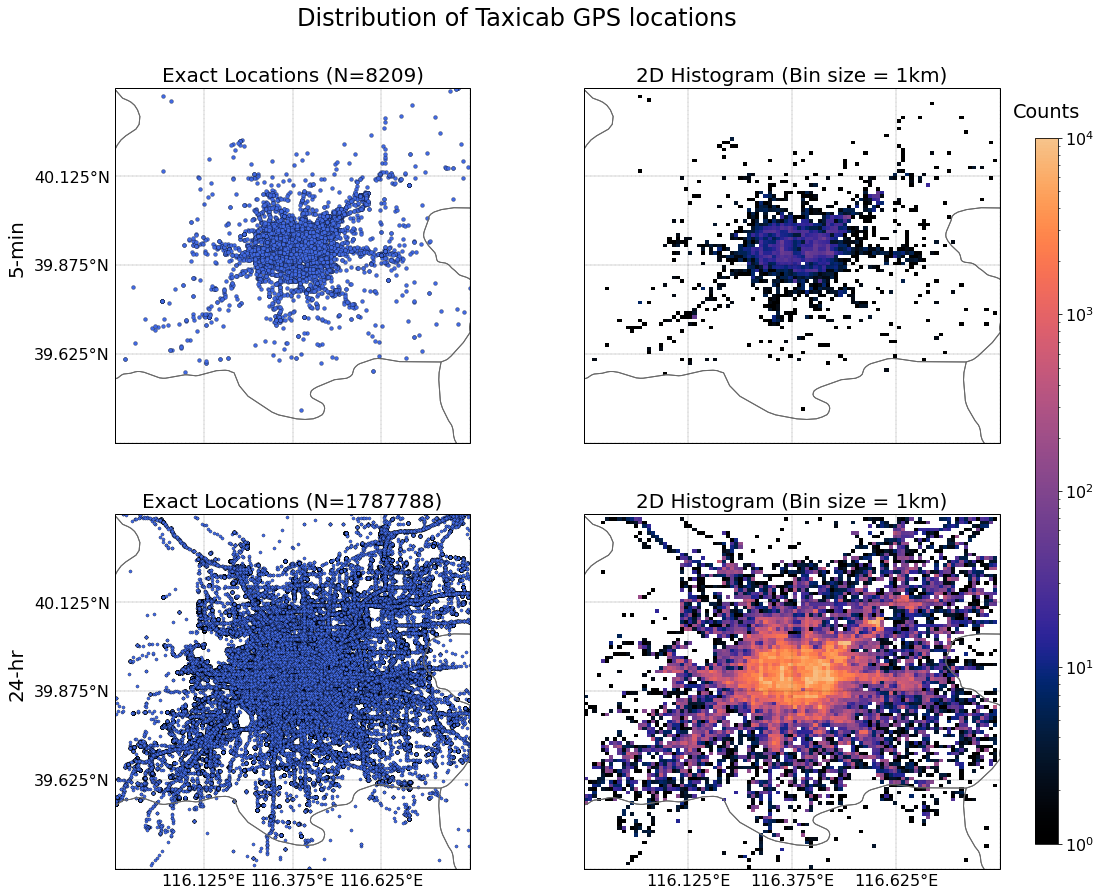

In [3]:
### --- (3) --- #
#Plot distribution of location data

#1-km Bins for histograms
xe = np.arange(minLng,maxLng,0.01)
ye = np.arange(minLat,maxLat,0.01)

#Set minimum font size for plot
fs=16
matplotlib.rcParams.update({'font.size': fs})

#Initialize figure
fig = plt.figure(figsize=(16,14))
#Plot point location data over 5-min period
ax1 = plt.subplot(221,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax1,'dimgray',1)
add_gridlines(ax1,False,True,'k',16) 
plt.scatter(llngs_5min,llats_5min,c='royalblue',s=15,linewidth=0.25,edgecolor='k')
ax1.set_xlim([minLng,maxLng])
ax1.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('Exact Locations (N='+str(len(llngs_5min))+')',fontsize=fs+4)
ax1.text(-0.25, 0.55, '5-min', fontsize=fs+4, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes)

#Plot 2D histogram of point location data over 5-min period
ax2 = plt.subplot(222,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax2,'dimgray',1)
add_gridlines(ax2,False,False,'k',16)    
#Generate 2D histogram 
H, xedges, yedges = np.histogram2d(llngs_5min, llats_5min, bins=(xe, ye))
H = H.T #Flip for imshow
H = np.ma.masked_where(H==0,H)  #mask where count is zero
#Display histogram
im = plt.imshow(H, aspect='auto', origin='lower',interpolation='none', extent=[xe.min(),xe.max(),ye.min(),ye.max()],norm=colors.LogNorm(),cmap=cmapp,vmin=1,vmax=1e4)
ax2.set_xlim([minLng,maxLng])
ax2.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('2D Histogram (Bin size = 1km)',fontsize=fs+4)

#Plot point location data over 24-hr period
ax3 = plt.subplot(223,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax3,'dimgray',1)
add_gridlines(ax3,True,True,'k',16) 
plt.scatter(llngs_24hr,llats_24hr,c='royalblue',s=10,linewidth=0.25,edgecolor='k')
ax3.set_xlim([minLng,maxLng])
ax3.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('Exact Locations (N='+str(len(llngs_24hr))+')',fontsize=fs+4)
ax3.text(-0.25, 0.55, '24-hr', fontsize=fs+4, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax3.transAxes)

#Plot 2D histogram of point location data over 24-hr period
ax4 = plt.subplot(224,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax4,'dimgray',1)
add_gridlines(ax4,True,False,'k',16)
#Generate 2D histogram 
H, xedges, yedges = np.histogram2d(llngs_24hr, llats_24hr, bins=(xe, ye))
H = H.T #Flip for imshow
H = np.ma.masked_where(H==0,H) #mask where count is zero
#Display histogram
im = plt.imshow(H, aspect='auto', origin='lower',interpolation='none', extent=[xe.min(),xe.max(),ye.min(),ye.max()],norm=colors.LogNorm(),cmap=cmapp,vmin=1,vmax=1e4)
ax4.set_xlim([minLng,maxLng])
ax4.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('2D Histogram (Bin size = 1km)',fontsize=fs+4)

#Adjust plot for titles and colorbar
plt.tight_layout(w_pad=3)
fig.subplots_adjust(right=0.92)
#Add colorbar on right
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb=fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('Counts',y=1.02) #rotation=0,labelpad=40)
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Taxicab GPS locations',fontsize=fs+8)
plt.show()

In [5]:
### --- (4) --- #
#Anonymize location data by combining Geo-Indistinguishability (citation) and K-Anonymity (Dwork, 2006)

#Import geo-indistinguishability method from python script geo_ind (adapted from: )
from geo_ind import LaplaceAlgorithm

#define function to anonymize location data
def perform_anon(llats,llngs):
    #Set parameters for geo-indistinguishability (Andres et al., 2013) to ensure moderate privacy protections along the lines of (Bordenbabe, 2014)

    # Geo-indistinguishability provides privacy within a certain radius (i.e. protection area) within which all locations look plausible for being the real one.
    # Privacy protections are achieved by adding random noise in a way such that all locations within the protection area can produce the same fake location with similar probability. 
    # As a result, the fake location provides no information for distinguishing between locations within the protection area. 
    
    rstar = 500.0 #Radius (protection area) - a user is equally likely to be within radius r. 
    estar = 2 #Privacy level (determines the amount of noise added to your real location) - higher privacy level overs larger protection within area.
    epsilon = estar/rstar #Epsilon parameter (radius/privacy level)

    lpa = LaplaceAlgorithm(epsilon) #Add bi-variate laplacian noise to a real locatoin (Bordenbabe, 2014)
    geo_lngs = []; geo_lats = []; geo_dist = []
    #Obfuscate locations under the notion of geo-indistinguishability
    for l in range(0,len(llats)):
        plng,plat = lpa.generate(llngs[l],llats[l])
        geo_lngs.append(plng)
        geo_lats.append(plat)

    geo_lats = np.array(geo_lats)
    geo_lngs = np.array(geo_lngs)

    #Generalize locations (Krumm, 2007) within the framework of k-anonymity by rounding geo-indistinguishable latitude/longitude pairs to the nearest 0.25 decimal degrees
    #This results in sets of locations within a 0.25 x 0.25 degree grid box being assigned an identical location (i.e. grid point) 
    grid_lats = 0.25*np.round(geo_lats/0.25)
    grid_lngs = 0.25*np.round(geo_lngs/0.25)

    #Store lat/lng points at each stage of anonymization to xarray dataset
    nobs = np.arange(0,len(llats))
    ds_locs = xr.Dataset()
    #Define latitude arrays
    ds_locs['lat_grid'] = xr.DataArray(grid_lats,coords={'nobs':nobs},dims=('nobs'))
    ds_locs['lat_geoind'] = xr.DataArray(geo_lats,coords={'nobs':nobs},dims=('nobs'))
    ds_locs['lat_true'] = xr.DataArray(llats,coords={'nobs':nobs},dims=('nobs'))
    #Define longitude arrays
    ds_locs['lng_grid'] = xr.DataArray(grid_lngs,coords={'nobs':nobs},dims=('nobs'))
    ds_locs['lng_geoind'] = xr.DataArray(geo_lngs,coords={'nobs':nobs},dims=('nobs'))
    ds_locs['lng_true'] = xr.DataArray(llngs,coords={'nobs':nobs},dims=('nobs'))
    #df_locs = ds_locs.to_dataframe()
    return ds_locs

#Anonymize 5-min data
ds_5min = perform_anon(llats_5min,llngs_5min)
#Anonymize 24-hr data
ds_24hr = perform_anon(llats_24hr,llngs_24hr)

/home/disk/p/cmcnich/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1123: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = matplotlib.axes.Axes.imshow(self, img, *args, **kwargs)
/home/disk/p/cmcnich/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1123: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = matplotlib.axes.Axes.imshow(self, img, *args, **kwargs)
/home/disk/p/cmcnich/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in

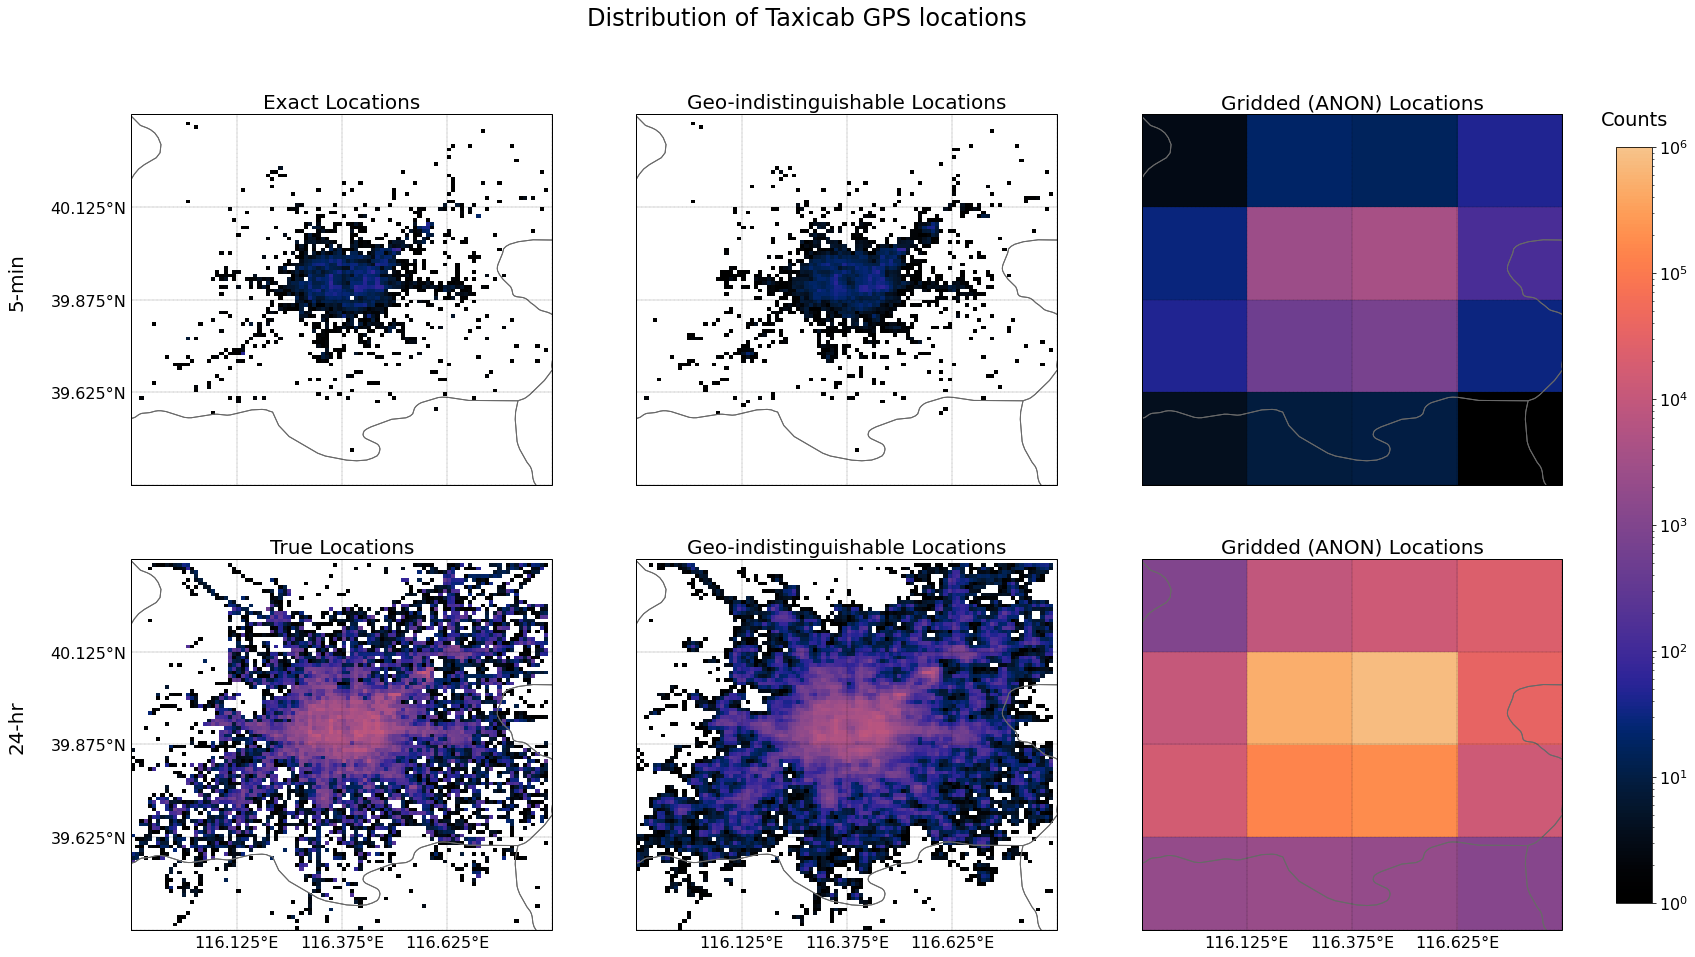

In [6]:
### --- (5) --- #
#Display location data at each stage of anonymization (similar to Fig. 3 in McNicholas and Mass, 2020a)

#Set minimum font size
matplotlib.rcParams.update({'font.size': fs})

fig = plt.figure(figsize=(25,15))
#Plot Exact locations over a 5-min period
ax1 = plt.subplot(231,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax1,'dimgray',1)
add_gridlines(ax1,False,True,'k',fs) 
#Add 5min time window label to the left of the x-axis
ax1.text(-0.25, 0.55, '5-min', fontsize=fs+4, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes)
#Bin locations in 2D histogram
H, xedges, yedges = np.histogram2d(ds_5min['lng_true'].values, ds_5min['lat_true'].values, bins=(xe, ye))
H = H.T
H = np.ma.masked_where(H==0,H) #mask where count is zero
im = plt.imshow(H, aspect='auto', origin='lower',interpolation='none', extent=[xe.min(),xe.max(),ye.min(),ye.max()],norm=colors.LogNorm(),cmap=cmapp,vmin=1,vmax=1e6)
ax1.set_xlim([minLng,maxLng])
ax1.set_ylim([minLat,maxLat])

plt.grid(True)
plt.title('Exact Locations',fontsize=fs+4)

#Plot geo-indistinguishable (obfuscated) locations over a 5-min period
ax2 = plt.subplot(232,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax2,'dimgray',1)
add_gridlines(ax2,False,False,'k',16)    
#Bin obfuscated locations in 2D histogram
H, xedges, yedges = np.histogram2d(ds_5min['lng_geoind'].values, ds_5min['lat_geoind'].values, bins=(xe, ye))
H = H.T
H = np.ma.masked_where(H==0,H) #Mask where bin count is zero
im = plt.imshow(H, aspect='auto', origin='lower',interpolation='none', extent=[xe.min(),xe.max(),ye.min(),ye.max()],norm=colors.LogNorm(),cmap=cmapp,vmin=1,vmax=1e6)
ax2.set_xlim([minLng,maxLng])
ax2.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('Geo-indistinguishable Locations',fontsize=fs+4)

#Plot k-anonymous (generalized) locations over a 5-min period
ax3 = plt.subplot(233,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax3,'dimgray',1)
add_gridlines(ax3,False,False,'k',16)    

#Get bin size for gridded data (Center box over grid point)
xeb = np.arange(ds_5min['lng_grid'].min()-0.125,ds_5min['lng_grid'].max()+0.375,0.25)
yeb = np.arange(ds_5min['lat_grid'].min()-0.125,ds_5min['lat_grid'].max()+0.375,0.25)

#Bin generalized locations in 2D histogram (note that generalization is performed as a second step in anonymization after obfuscation)
H, xedges, yedges = np.histogram2d(ds_5min['lng_grid'].values,ds_5min['lat_grid'].values, bins=(xeb, yeb))
H = H.T
H = np.ma.masked_where(H==0,H)
im = plt.imshow(H, aspect='auto', origin='lower',interpolation='none', extent=[xeb.min(),xeb.max(),yeb.min(),yeb.max()],norm=colors.LogNorm(),cmap=cmapp,vmin=1,vmax=1e6)
ax3.set_xlim([minLng,maxLng])
ax3.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('Gridded (ANON) Locations',fontsize=fs+4)

#Plot Exact locations over 24-hr period
ax4 = plt.subplot(234,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax4,'dimgray',1)
add_gridlines(ax4,True,True,'k',fs) 
#Add 24-hr time window label to the left of the x-axis
ax4.text(-0.25, 0.55, '24-hr', fontsize=fs+4, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax4.transAxes)
#Bin locations in 2D histogram
H, xedges, yedges = np.histogram2d(ds_24hr['lng_true'].values, ds_24hr['lat_true'].values, bins=(xe, ye))
H = H.T
H = np.ma.masked_where(H==0,H) #Mask where bin count is zero
im = plt.imshow(H, aspect='auto', origin='lower',interpolation='none', extent=[xe.min(),xe.max(),ye.min(),ye.max()],norm=colors.LogNorm(),cmap=cmapp,vmin=1,vmax=1e6)
ax4.set_xlim([minLng,maxLng])
ax4.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('True Locations',fontsize=fs+4)

#Plot geo-indistinguishable (obfuscated) locations over 24-hr period
ax5 = plt.subplot(235,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax5,'dimgray',1)
add_gridlines(ax5,True,False,'k',fs)    
#Bin obfuscated locations in 2D histogram
H, xedges, yedges = np.histogram2d(ds_24hr['lng_geoind'].values, ds_24hr['lat_geoind'].values, bins=(xe, ye))
H = H.T
H = np.ma.masked_where(H==0,H) #Mask where bin count is zero
im = plt.imshow(H, aspect='auto', origin='lower',interpolation='none', extent=[xe.min(),xe.max(),ye.min(),ye.max()],norm=colors.LogNorm(),cmap=cmapp,vmin=1,vmax=1e6)
ax5.set_xlim([minLng,maxLng])
ax5.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('Geo-indistinguishable Locations',fontsize=fs+4)

#Plot k-anonymous (generalized) locations over 24-hr period
ax6 = plt.subplot(236,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax6,'dimgray',1)
add_gridlines(ax6,True,False,'k',fs)

#Get bin size for gridded data (Center box over grid point)
xeb = np.arange(ds_24hr['lng_grid'].min()-0.125,ds_24hr['lng_grid'].max()+0.375,0.25)
yeb = np.arange(ds_24hr['lat_grid'].min()-0.125,ds_24hr['lat_grid'].max()+0.375,0.25)

#Bin generalized locations in 2D histogram (note that generalization is performed as a second step in anonymization after obfuscation)
H, xedges, yedges = np.histogram2d(ds_24hr['lng_grid'].values,ds_24hr['lat_grid'].values, bins=(xeb, yeb))
H = H.T
H = np.ma.masked_where(H==0,H)
im = plt.imshow(H, aspect='auto', origin='lower',interpolation='none', extent=[xeb.min(),xeb.max(),yeb.min(),yeb.max()],norm=colors.LogNorm(),cmap=cmapp,vmin=1,vmax=1e6)
ax6.set_xlim([minLng,maxLng])
ax6.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('Gridded (ANON) Locations',fontsize=fs+4)

#Adjust sbuplots and add colorbar
fig.subplots_adjust(right=0.92)
# put colorbar at #Position colorbar and add subplot title 
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb=fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('Counts',y=1.02) #rotation=0,labelpad=40)
plt.suptitle('Distribution of Taxicab GPS locations',fontsize=fs+8)
plt.show()

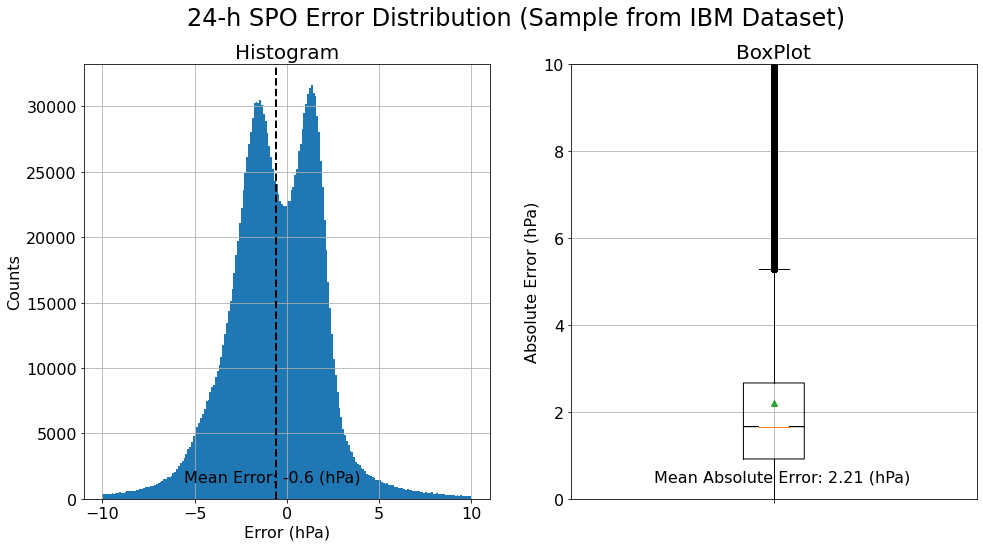

In [7]:
### --- (6) --- #
#Show the distribution of pressure errors drawn from a sample of real IBM SPO errors (McNicholas and Mass, 2020a)

#Retrieve pressure errors from random samples of IBM smartphone pressure observation errors 
ds_err_5min = xr.open_dataset('sample_pressure_errors/pressure_error_tdrive_5min.nc')
ds_err_24hr = xr.open_dataset('sample_pressure_errors/pressure_error_tdrive_24hr.nc')

#Add pressure error to xarray dataset
ds_5min['pressure_error'] = xr.DataArray(ds_err_5min['uncorrected_error'].values,coords=ds_5min.coords,dims=ds_5min.dims)
ds_24hr['pressure_error'] = xr.DataArray(ds_err_24hr['uncorrected_error'].values,coords=ds_24hr.coords,dims=ds_24hr.dims)

ds_err_5min.close()
ds_err_24hr.close()

#Plot Distribution of pressure errors for 24-hr period
matplotlib.rcParams.update({'font.size': fs})
plt.figure(figsize=(16,8))
ax1=plt.subplot(121)
#Show histogram of pressure errors
plt.hist(ds_24hr['pressure_error'].values,bins=np.arange(-10,10.1,0.1))
plt.axvline(x=np.mean(ds_24hr['pressure_error'].values),color='k',ls='--',lw=2)
#Add text denoting the mean pressure error
ax1.text(0.465, 0.05, 'Mean Error: '+str(round(np.mean(ds_24hr['pressure_error'].values),2))+' (hPa)', fontsize=fs, va='center', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax1.transAxes)
plt.grid(True)
plt.title('Histogram',fontsize=fs+4)
plt.xlabel('Error (hPa)')
plt.ylabel('Counts')
#Show a boxplot of absolute pressure error
ax2=plt.subplot(122)
plt.boxplot(abs(ds_24hr['pressure_error'].values),notch=True,showmeans=True)
#Add text denoting the mean absolute pressure error
ax2.text(0.52, 0.05, 'Mean Absolute Error: '+str(round(np.mean(abs(ds_24hr['pressure_error'].values)),2))+' (hPa)', fontsize=fs, va='center', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax2.transAxes)
plt.ylim([0,10])
plt.grid(True)
ax2.set_xticklabels("")
ax2.set_ylabel('Absolute Error (hPa)')
plt.title('BoxPlot',fontsize=fs+4)
#Adjust subplots and add title
plt.subplots_adjust(top=0.88)
plt.suptitle('24-h SPO Error Distribution (Sample from IBM Dataset)',fontsize=fs+8)
plt.show()

In [8]:
### --- (7) --- #
#Create synthetic pressure observations at social network check-in location to simulate a network of SPOs.
#Assign pressure errors to synthetic pressure observations using a random sample of real IBM SPO errors (McNicholas and Mass, 2020a)

#Synthetic pressure equation
def pres_eq(lat_arr,lng_arr):
    #Create ~2 hPa pressure gradient across the region, along a northwest-southeast axis
    pres = (lat_arr-minLat)*2 + (lng_arr-minLng)*1 + 1013.25
    return pres

#Generate sample pressure data and create ANON super-obs
def get_pres_ds(ds_data):
    #Create synthetic pressure observations adding real smartphone pressure observation errors sampled from IBM (McNicholas and Mass, 2020a).
    pres = pres_eq(ds_data['lat_true'].values,ds_data['lng_true'].values)
    pres = pres + ds_data['pressure_error'].values
    
    #Add synthetic pressure observations to dataset
    ds_data['pressure'] = xr.DataArray(pres,coords=ds_data['lat_true'].coords,dims=ds_data['lat_true'].dims)
    #Super-ob ANON pressure observations 
    dsg1 = ds_data.groupby('lat_grid')
    ds_all = []
    for d1 in dsg1:
        #Remove non-anon locations
        dd1 = d1[1].drop(['lat_geoind','lng_geoind','lng_true','lat_true'])
        #Retrieve observations within a 0.25 x 0.25 degree box
        dsg2 = dd1.groupby('lng_grid')
        for d2 in dsg2:
            dd2 = d2[1]
            #Remove outliers to avoid skewing super-obs
            pres = dd2['pressure'].values
            mean_diff = pres-np.nanmean(pres) #Compute the difference between pressure obserations and the mean
            thresh = np.nanstd(pres)*3.0 #Set threshold to 3 standard deviations from the mean
            #if the difference between the pressure ob and the mean exceeds three standard deviations exclude the ob from the super-observation
            gidx = np.argwhere(abs(mean_diff)<thresh).T[0]
            dd2 = dd2.isel(nobs=gidx)
            
            #Calculate the super-observation
            dd22 = dd2.mean()
            ds_all.append(dd22)

    #Combine and sort to produce a dataset containing ANON super-observations 
    ds_super = xr.concat(ds_all,'nobs')
    ds_super = ds_super.sortby('nobs')
    ds_super = ds_super.dropna(how='any',dim='nobs')
    #Return pressure dataset and super-obbed pressure dataset
    return ds_data,ds_super

In [9]:
### --- (8) --- #
#Show data in table format to highlight how the location and pressure data would look before and after anonymization

# Create synthetic pressure observations at taxicab GPS locations to simulate a network of SPOs.
# Assign pressure errors to synthetic pressure observations using a random sample of real IBM SPO errors (McNicholas and Mass, 2020a)
# Add synthetic pressure observations (w. errors) to location dataset to simulate real smartphone pressure network.
dsp_24hr,dss_24hr = get_pres_ds(ds_24hr) 
dsp_5min,dss_5min = get_pres_ds(ds_5min) 

#Convert xarray datasets to pandas dataframe
dfp_24hr = dsp_24hr.to_dataframe()
dfs_24hr = dss_24hr.to_dataframe()

#Breakup data to display in side-by-side tables
nb = 10
df4 = dfp_24hr.iloc[0:nb,[6]] #Synthetic pressure observations
df3 = dfp_24hr.iloc[0:nb,[0,3]] #ANON locations
df2 = dfp_24hr.iloc[0:nb,[1,4]] #Geo-indistinguishable (GeoInd) locations
df1 = dfp_24hr.iloc[0:nb,[2,5]] #Exact locations

#Show how non-anonymous data appears in table format.
display_side_by_side([df1, df2, df3, df4], ['True Locations', 'GeoInd Locations', 'ANON Locations', 'Synthetic Pressure'])

/home/disk/p/cmcnich/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


,lat_true,lng_true
nobs,,
0,39.881480,116.486670
1,39.881480,116.486670
2,39.881660,116.486600
3,39.880690,116.482850
4,39.880730,116.482690
5,39.880580,116.485600
6,39.877830,116.491170
7,39.869020,116.507840
8,39.866210,116.506970


In [10]:
#Show how anonymous dataset appears in table format
display_side_by_side([dfs_24hr.iloc[0:10,:]], ['ANON Super-obs'])

,lat_grid,lng_grid,pressure_error,pressure
nobs,,,,
0,39.500000,115.750000,-0.184024,1013.441879
1,39.500000,116.000000,-0.562256,1013.251453
2,39.500000,116.250000,-0.611508,1013.444093
3,39.500000,116.500000,-0.588411,1013.667241
4,39.500000,116.750000,-0.475410,1014.038932
5,39.750000,116.000000,-0.562279,1013.575753
6,39.750000,116.250000,-0.575541,1013.984054
7,39.750000,116.500000,-0.559454,1014.162655
8,39.750000,116.750000,-0.547495,1014.371338


/home/disk/p/cmcnich/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/home/disk/p/cmcnich/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


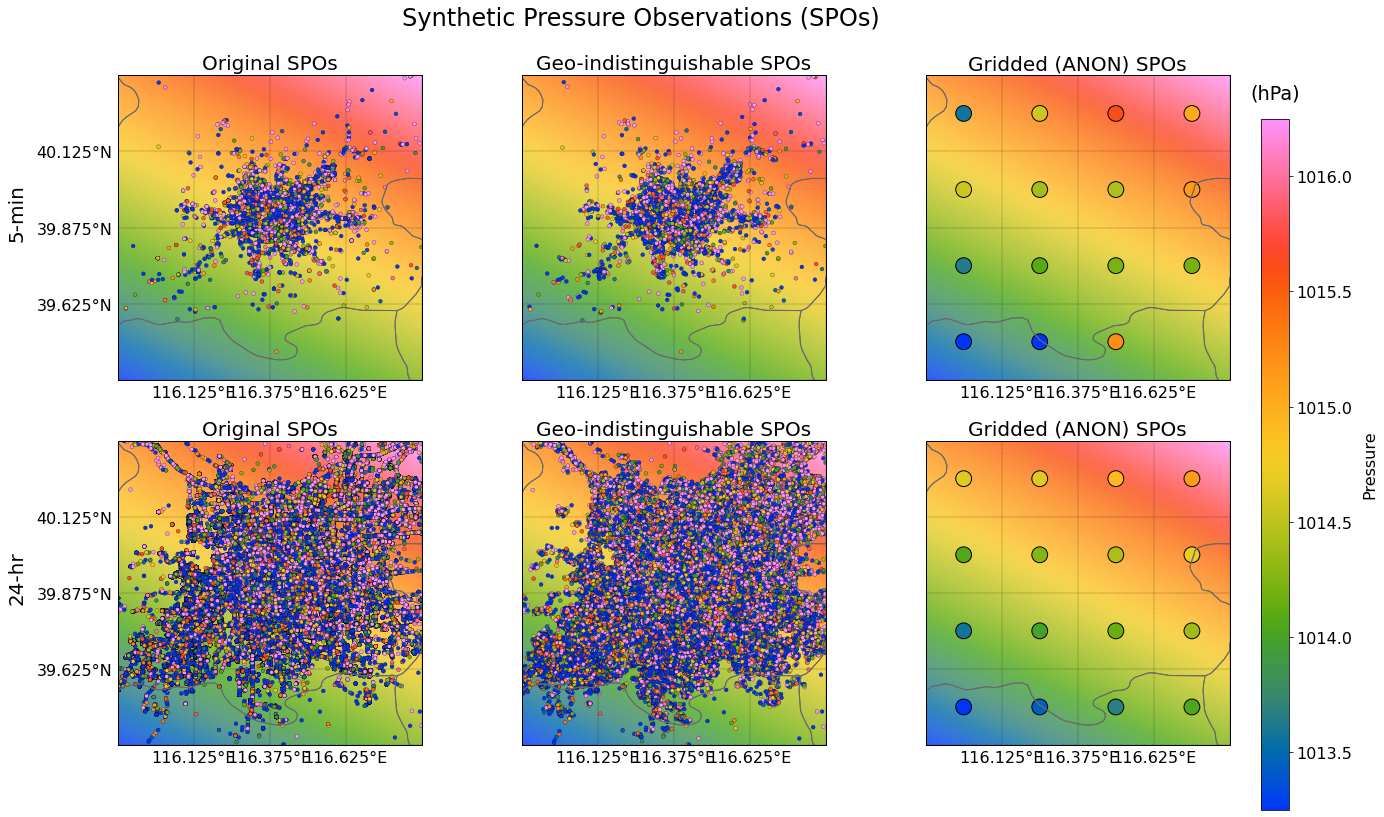

In [11]:
### --- (9) --- #
#Display synthetic pressure observations, at each stage of anonymization.

#Set minimum font size for plot
matplotlib.rcParams.update({'font.size': fs})
#Create gridded (truth) pressure analysis for comparison with observations 
X,Y = np.meshgrid(np.arange(minLng,maxLng+0.01,0.01),np.arange(minLat,maxLat+0.01,0.01))
grid_pres = np.zeros(X.shape)
for i in range(0,X.shape[0]):
    for j in range(0,X.shape[1]):
        grid_pres[i,j] = pres_eq(Y[i,j],X[i,j]) #True pressure distribution

#Set min/max pressure for colormapping
pmin = 1013.25
pmax = 1016.25

fig = plt.figure(figsize=(20,12))

#Display synthetic pressure observations at exact locations retrieved over a 5-min period
ax1 = plt.subplot(231,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax1,'dimgray',1)
add_gridlines(ax1,True,True,'k',fs) 
#Display true distribution of pressure
im=ax1.imshow(grid_pres,origin='lower',extent=[X.min(),X.max(),Y.min(),Y.max()],vmin=pmin,vmax=pmax,cmap=cmapp2,alpha=0.8)
#Overlay synthetic pressure observations (with realistic pressure errors)
plt.scatter(ds_5min['lng_true'].values,ds_5min['lat_true'].values,c=ds_5min['pressure'].values,s=15,edgecolor='k',linewidth=0.25,cmap=cmapp2,vmin=pmin,vmax=pmax)
ax1.set_xlim([minLng,maxLng])
ax1.set_ylim([minLat,maxLat])
ax1.text(-0.3, 0.55, '5-min', fontsize=fs+4, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes)
plt.grid(True)
plt.title('Original SPOs',fontsize=fs+4)

#Display synthetic pressure observations at geo-indistinguishable locations retrieved over a 5-min period
ax2 = plt.subplot(232,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax2,'dimgray',1)
add_gridlines(ax2,True,False,'k',16)    
#Display true distribution of pressure
im=ax2.imshow(grid_pres,origin='lower',extent=[X.min(),X.max(),Y.min(),Y.max()],vmin=pmin,vmax=pmax,cmap=cmapp2,alpha=0.8)
#Overlay synthetic pressure observations (with realistic pressure errors) at geo-indistinguishable locations
#Note that obfuscating locations has no affect on the pressure observation. At this stage in anonymization the only thing that changes is the latitude and longitude position of the observation
plt.scatter(ds_5min['lng_geoind'].values,ds_5min['lat_geoind'].values,c=ds_5min['pressure'].values,s=15,edgecolor='k',linewidth=0.25,cmap=cmapp2,vmin=pmin,vmax=pmax)
ax2.set_xlim([minLng,maxLng])
ax2.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('Geo-indistinguishable SPOs',fontsize=fs+4)

#Display synthetic anonymous (ANON) pressure obserations at grid-point (k-anonymous) locations
ax3 = plt.subplot(233,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax3,'dimgray',1)
add_gridlines(ax3,True,False,'k',16)    
#Display true distribution of pressure
im=ax3.imshow(grid_pres,origin='lower',extent=[X.min(),X.max(),Y.min(),Y.max()],vmin=pmin,vmax=pmax,cmap=cmapp2,alpha=0.8)
#Overlay synthetic ANON pressure observations. Note that these observations are super-obserations (i.e. averages of SPOs whose locations were rounded to the same grid-point within a 0.25 x 0.25 degree grid box)
im=plt.scatter(dss_5min['lng_grid'].values,dss_5min['lat_grid'].values,c=dss_5min['pressure'].values,edgecolor='k',linewidth=1,s=250,cmap=cmapp2,vmin=pmin,vmax=pmax)
ax3.set_xlim([minLng,maxLng])
ax3.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('Gridded (ANON) SPOs',fontsize=fs+4)

#Display synthetic pressure observations at exact locations retrieved over a 24-hr period
ax4 = plt.subplot(234,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax4,'dimgray',1)
add_gridlines(ax4,True,True,'k',fs)
#Display true distribution of pressure
im=ax4.imshow(grid_pres,origin='lower',extent=[X.min(),X.max(),Y.min(),Y.max()],vmin=pmin,vmax=pmax,cmap=cmapp2,alpha=0.8)
#Overlay synthetic pressure observations (with realistic pressure errors)
plt.scatter(ds_24hr['lng_true'].values,ds_24hr['lat_true'].values,c=ds_24hr['pressure'].values,s=15,edgecolor='k',linewidth=0.25,cmap=cmapp2,vmin=pmin,vmax=pmax)
ax4.set_xlim([minLng,maxLng])
ax4.set_ylim([minLat,maxLat])
ax4.text(-0.3, 0.55, '24-hr', fontsize=fs+4, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax4.transAxes)
plt.grid(True)
plt.title('Original SPOs',fontsize=fs+4)

#Display synthetic pressure observations at geo-indistinguishable locations retrieved over a 24-hr period
ax5 = plt.subplot(235,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax5,'dimgray',1)
add_gridlines(ax5,True,False,'k',16)  
#Display true distribution of pressure
im=ax5.imshow(grid_pres,origin='lower',extent=[X.min(),X.max(),Y.min(),Y.max()],vmin=pmin,vmax=pmax,cmap=cmapp2,alpha=0.8)
#Overlay synthetic pressure observations (with realistic pressure errors) at geo-indistinguishable locations
#Note that obfuscating locations has no affect on the pressure observation. At this stage in anonymization the only thing that changes is the latitude and longitude position of the observation
plt.scatter(ds_24hr['lng_geoind'].values,ds_24hr['lat_geoind'].values,c=ds_24hr['pressure'].values,s=15,edgecolor='k',linewidth=0.25,cmap=cmapp2,vmin=pmin,vmax=pmax)
ax5.set_xlim([minLng,maxLng])
ax5.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('Geo-indistinguishable SPOs',fontsize=fs+4)

#Display synthetic anonymous (ANON) pressure obserations at grid-point (k-anonymous) locations rertrieved over a 24-hr period
ax6 = plt.subplot(236,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax6,'dimgray',1)
add_gridlines(ax6,True,False,'k',16)    
#Display true distribution of pressure
im=ax6.imshow(grid_pres,origin='lower',extent=[X.min(),X.max(),Y.min(),Y.max()],vmin=pmin,vmax=pmax,cmap=cmapp2,alpha=0.8)
#Overlay synthetic ANON pressure observations. Note that these observations are super-obserations (i.e. averages of SPOs whose locations were rounded to the same grid-point within a 0.25 x 0.25 degree grid box)
im=plt.scatter(dss_24hr['lng_grid'].values,dss_24hr['lat_grid'].values,c=dss_24hr['pressure'].values,edgecolor='k',linewidth=1,s=250,cmap=cmapp2,vmin=pmin,vmax=pmax)
ax6.set_xlim([minLng,maxLng])
ax6.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('Gridded (ANON) SPOs',fontsize=fs+4)

#Adjust subplot and add title/colorbar.
plt.tight_layout(h_pad=2.5)
plt.subplots_adjust(top=0.9)
fig.subplots_adjust(right=0.92)
#Set colorbar position
cbar_ax = fig.add_axes([0.93, 0.05, 0.02, 0.8])
cb=fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('(hPa)',y=1.02)#,rotation=0,labelpad=40)
cb.ax.set_ylabel('Pressure',labelpad=10)
plt.suptitle('Synthetic Pressure Observations (SPOs)',fontsize=fs+8)
plt.show()

/home/disk/p/cmcnich/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


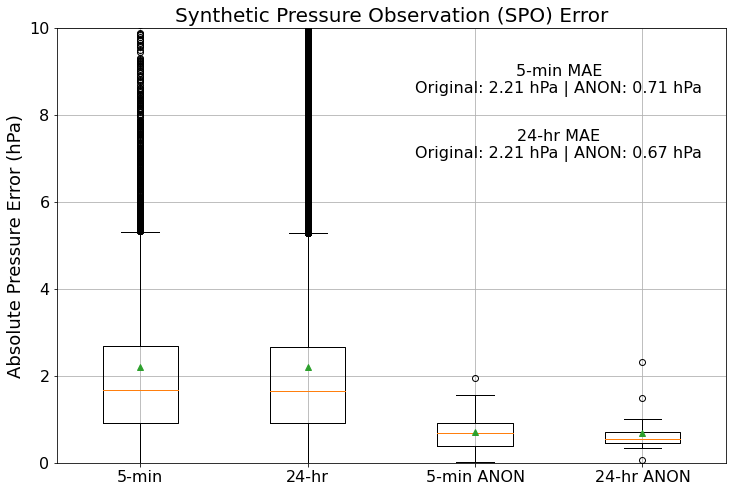

In [12]:
### --- (10) --- #
#Show the distribution of pressure observations errors, at each stage of anonymization, and plot the results on a map.

#Retrieve error statistics for original obs
err_true_5min = dsp_5min['pressure_error'].values
err_true_24hr = dsp_24hr['pressure_error'].values

#Calculate error statistics super-obs
err_anon_5min = calc_pres_err(dss_5min)
err_anon_24hr = calc_pres_err(dss_24hr)

#Add gridded (ANON) SPO error statistics to xarray datasets
dss_5min['pressure_error'] = xr.DataArray(err_anon_5min,coords=dss_5min['lat_grid'].coords,dims=dss_5min['lat_grid'].dims)
dss_24hr['pressure_error'] = xr.DataArray(err_anon_24hr,coords=dss_24hr['lat_grid'].coords,dims=dss_24hr['lat_grid'].dims)

#Compute the MAE for synthetic pressure obs
mae_5min = round(mae(ds_5min['pressure_error'].values,axis=0),2)
mae_24hr = round(mae(ds_24hr['pressure_error'].values,axis=0),2)
#Compute the MAE for ANON super-obs
mae_sp_5min = round(mae(dss_5min['pressure_error'].values,axis=0),2)
mae_sp_24hr = round(mae(dss_24hr['pressure_error'].values,axis=0),2)

#Plot the distribution of absolute pressure error for non-anonymous and anonymous SPOs.
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(111)
plt.boxplot(np.abs([err_true_5min,err_true_24hr,err_anon_5min,err_anon_24hr]),showmeans=True)
ax1.set_xticklabels(['5-min','24-hr','5-min ANON','24-hr ANON'])
ax1.set_ylim([0,10])
#Add annotations to denote the MAE and RMSE of synthetic pressure obs
ax1.text(0.75, 0.88, '5-min MAE\nOriginal: '+str(mae_5min)+' hPa | ANON: '+str(mae_sp_5min)+' hPa', fontsize=fs, va='center', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax1.transAxes)
ax1.text(0.75, 0.73, '24-hr MAE\nOriginal: '+str(mae_24hr)+' hPa | ANON: '+str(mae_sp_24hr)+' hPa', fontsize=fs, va='center', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax1.transAxes)
plt.ylabel('Absolute Pressure Error (hPa)',fontsize=fs+2)
plt.title('Synthetic Pressure Observation (SPO) Error',fontsize=fs+4)
plt.grid(True)
plt.show()

/home/disk/p/cmcnich/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


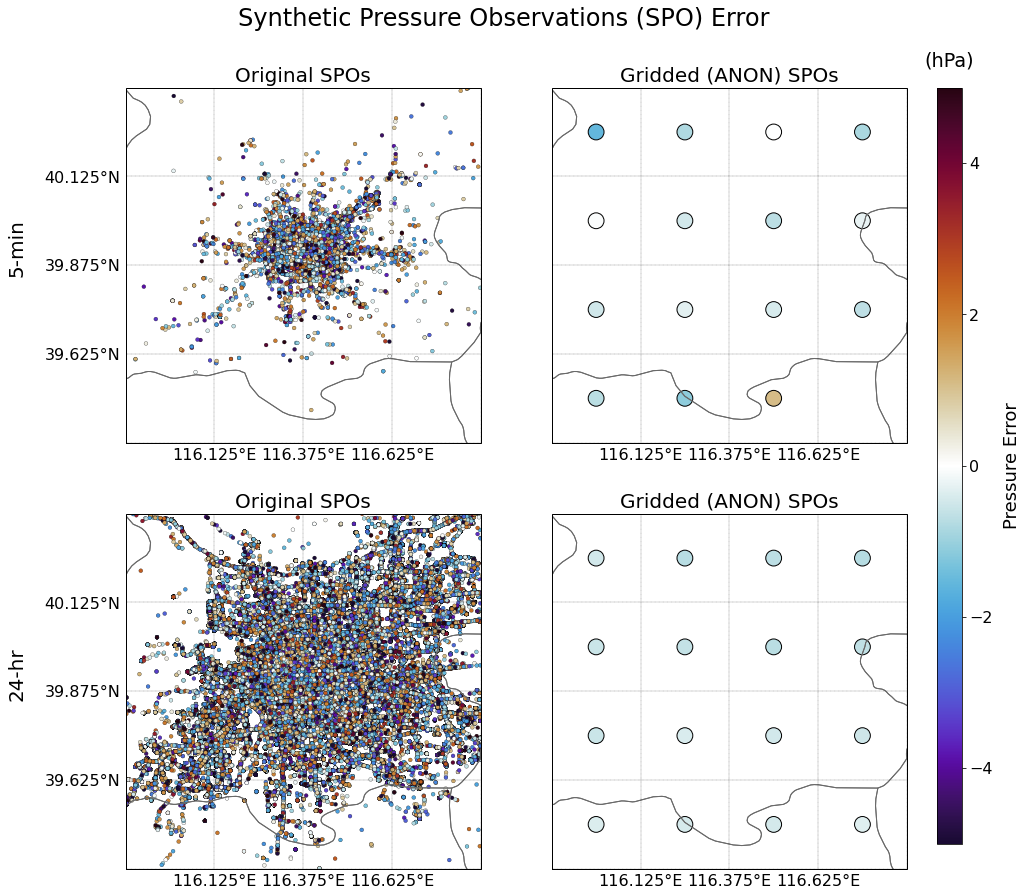

In [18]:
#Plot spatial distribution of synthetic pressure observation error

#Set minimum fontsize for figure
matplotlib.rcParams.update({'font.size': fs})

#Set pressure error limits for colorbar
emin = -5
emax = 5

fig = plt.figure(figsize=(14,14))
#Display original SPO error at exact locations retrieved over a 5-min period
ax1 = plt.subplot(221,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax1,'dimgray',1)
add_gridlines(ax1,True,True,'k',fs) 
plt.scatter(ds_5min['lng_true'].values,ds_5min['lat_true'].values,c=ds_5min['pressure_error'].values,s=15,edgecolor='k',linewidth=0.25,cmap=cmr.fusion_r,vmin=emin,vmax=emax)
ax1.set_xlim([minLng,maxLng])
ax1.set_ylim([minLat,maxLat])
ax1.text(-0.28, 0.55, '5-min', fontsize=fs+4, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes)
plt.grid(True)
plt.title('Original SPOs',fontsize=fs+4)

#Display super-obbed ANON SPO error at gridded (k-anonymous) locations retrieved over a 5-min period
ax2 = plt.subplot(222,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax2,'dimgray',1)
add_gridlines(ax2,True,False,'k',16)    
im=plt.scatter(dss_5min['lng_grid'].values,dss_5min['lat_grid'].values,c=dss_5min['pressure_error'].values,edgecolor='k',linewidth=1,s=250,cmap=cmr.fusion_r,vmin=emin,vmax=emax)
ax2.set_xlim([minLng,maxLng])
ax2.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('Gridded (ANON) SPOs',fontsize=fs+4)

#Display original SPO error at exact locations retriegved over a 24-hr period
ax3 = plt.subplot(223,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax3,'dimgray',1)
add_gridlines(ax3,True,True,'k',fs) 
plt.scatter(ds_24hr['lng_true'].values,ds_24hr['lat_true'].values,c=ds_24hr['pressure_error'].values,s=15,edgecolor='k',linewidth=0.25,cmap=cmr.fusion_r,vmin=emin,vmax=emax)
ax3.set_xlim([minLng,maxLng])
ax3.set_ylim([minLat,maxLat])
ax3.text(-0.28, 0.55, '24-hr', fontsize=fs+4, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax3.transAxes)
plt.grid(True)
plt.title('Original SPOs',fontsize=fs+4)

#Display super-obbed ANON SPO error at gridded (k-anonymous) locations retrieved over a 24-hr period
ax4 = plt.subplot(224,projection=crs.PlateCarree())
#Add cartopy map features to plot
add_map(ax4,'dimgray',1)
add_gridlines(ax4,True,False,'k',16)    
im=plt.scatter(dss_24hr['lng_grid'].values,dss_24hr['lat_grid'].values,c=dss_24hr['pressure_error'].values,edgecolor='k',linewidth=1,s=250,cmap=cmr.fusion_r,vmin=emin,vmax=emax)
ax4.set_xlim([minLng,maxLng])
ax4.set_ylim([minLat,maxLat])
plt.grid(True)
plt.title('Gridded (ANON) SPOs',fontsize=fs+4)

#Adjust subplots, add title, and add colorbar
plt.tight_layout(h_pad=2)
plt.subplots_adjust(top=0.9)
fig.subplots_adjust(right=0.9)
#Set colorbar position
cbar_ax = fig.add_axes([0.93, 0.15, 0.025, 0.75])
cb=fig.colorbar(im, cax=cbar_ax)
cb.ax.set_title('(hPa)',y=1.02)#,rotation=0,labelpad=40)
cb.ax.set_ylabel('Pressure Error',labelpad=10,fontsize=fs+2)
plt.suptitle('Synthetic Pressure Observations (SPO) Error',fontsize=fs+8)
plt.show()